# Sequence Tagging: Bidirectional LSTM + CNN

Source: https://github.com/FanhuaandLuomu/BiLstm_CNN_CRF_CWS/blob/master/bilstm_cnn_crf.py

Num sentences =  31813
Num words in training set =  24819


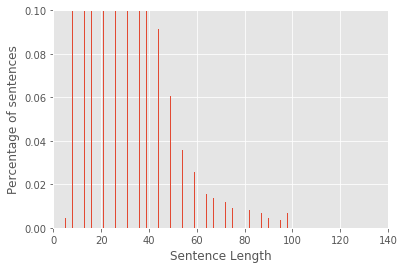

In [2]:
import glob, os, csv, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# AUTO-LABELLED DATA SET = TRAIN SET + VALIDATION SET
filename = r"../1-2 OzROCK/Files/OzROCK dataset/BIG_set_byDictionary.txt"
words = []
tags = []
sentences = []

with open(filename, 'r') as file :
    currSentence = []
    lines = []
    for line in file:
        cols = line.split(" ") # should be lower-case already
        if line.strip() == '':
            # Reset sentence            
            sentences.append(currSentence)
            currSentence = []
        elif len(cols) > 2:
            print(line)
        else:
            currSentence.append([cols[0].strip(), cols[1].strip()])
            words.append(cols[0].strip())
            tags.append(cols[1].strip())
print('Num sentences = ', len(sentences)) # 18589; 160,343

words = list(set(words))
print('Num words in training set = ', len(words))

train_sent_lengths = [len(s) for s in sentences]

plt.hist(train_sent_lengths, density=1, bins=1000) # x value is bins
plt.axis([0, 140, 0, 0.1])  # xmin,xmax,ymin,ymax
plt.xlabel('Sentence Length')
plt.ylabel('Percentage of sentences')

plt.show()

In [3]:
words.append("ENDPAD")
n_words = len(words) # unique words per file
print("Number of unique words in this file: ", n_words)

tags = list(set(tags))
n_tags = len(tags)
print("Number of unique tags in this file: ", n_tags)

Number of unique words in this file:  24820
Number of unique tags in this file:  13


In [4]:
max_len = 100

word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

print(word2idx["gold"]) # id=3818
print(tag2idx["B-MINERAL"]) # id = 9

17258
12


In [5]:
# Map the senctences to a sequence of numbers and then pad the sequence
# We increased the index of the words by one to use zero as a padding value, 
# because we want to use the mask_zero parameter of the embedding layer to ignore inputs with value zero

from keras.preprocessing.sequence import pad_sequences

X = [[word2idx[w[0]] for w in s] for s in sentences]

# Pad the sentences
#X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words-1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

Using TensorFlow backend.


In [6]:
words[0] = 'NaN'

#words[:10]
print(X[1])
print(y[1])

[  556 14791 11523  1266 22050 20068 15677  9482 16221 15031 12938  1395
 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819
 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819
 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819
 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819
 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819
 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819
 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819
 24819 24819 24819 24819]
[ 0  0  0 12 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]


In [7]:
from keras.utils import to_categorical # Converts a class vector (integers) to binary class matrix.

# Converts a class vector (integers) to binary class matrix (each class as a one-hot vector)
y = [to_categorical(i, num_classes=n_tags) for i in y]

print(X[1])
print(y[1])

[  556 14791 11523  1266 22050 20068 15677  9482 16221 15031 12938  1395
 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819
 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819
 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819
 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819
 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819
 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819
 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819 24819
 24819 24819 24819 24819]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [8]:
# We split in train and test set.
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)

In [9]:
print(X_tr.shape)
print(len(y_tr))
print(X_te.shape)
print(len(y_te))

(25450, 100)
25450
(6363, 100)
6363


In [10]:
import string
chars = [s for s in string.printable]
n_chars = len(chars)
print(n_chars)
#chars

100


In [11]:
import keras
from keras.layers import *
from keras.models import *
from keras_contrib.layers import CRF

#from keras import backend as K

from keras.utils import plot_model
from keras.utils import np_utils

# input:
# maxlen  char_value_dict_len  class_label_count
def Bilstm_CNN_Crf(maxlen, char_value_dict_len, class_label_count):
    
    word_input = Input(shape=(maxlen,), dtype='int32', name='word_input')
    
    word_emb = Embedding(char_value_dict_len + 2, output_dim=64, input_length=maxlen, name='word_emb')(word_input)
    
    ### word emb - bilstm
    bilstm = Bidirectional(LSTM(32, return_sequences=True))(word_emb)
    bilstm_d = Dropout(0.1)(bilstm)

    ### character emb - cnn
    half_window_size=2
    padding_layer=ZeroPadding1D(padding=half_window_size)(word_emb)
    
    conv=Conv1D(nb_filter=50, filter_length=2*half_window_size+1, padding='valid')(padding_layer)
    conv_d=Dropout(0.1)(conv)
    dense_conv=TimeDistributed(Dense(50))(conv_d)

    #char_input = Input(shape=(maxCharSize * max_words,), dtype='int32', name='char_input')
    #char_emb = Embedding(char_vocab_size, char_embedding_dim, input_length=max_words*maxCharSize, dropout=dropout, name='char_emb')(char_input)
    #char_cnn = Convolution1D(nb_filter=nb_filters,filter_length= window_length, activation='tanh', border_mode='full') (char_emb) 
    #char_max_pooling = MaxPooling1D(pool_length=maxCharSize) (char_cnn) #  get output per word. this is the size of the hidden layer

    ### MERGE 
    #rnn_cnn_merge = merge([bilstm_d,dense_conv],mode='concat',concat_axis=2)
    #rnn_cnn_merge = concatenate([bilstm_d,dense_conv], axis = 2)
    
    #rnn_cnn_merge = merge([bilstm_d, dense_conv], mode='concat', concat_axis=2, name ='rnn_cnn_merge')
    #emb_droput = Dropout(dropout)(total_emb)
    
    ##### ????????????
    #dense=TimeDistributed(Dense(class_label_count))(rnn_cnn_merge)
    dense = TimeDistributed(Dense(class_label_count))(dense_conv) # 14 classes or half of rnn_cnn_merge = 57

    #dense = TimeDistributed(Dense(50, activation="relu"))(rnn_cnn_merge)  # a dense layer as suggested by neuralNer

    ### CRF
    crf = CRF(class_label_count, sparse_target=False)
    #crf = CRF(class_label_count)  # CRF layer
    crf_output = crf(dense)  # output
    
    # build model
    model = Model(input = [word_input], output = [crf_output])
    #model = Model(input = word_input, output = crf_output)

    model.compile(loss=crf.loss_function, optimizer='adam', metrics=[crf.accuracy]) # optimizer="rmsprop"

    #model.summary()
    return model

In [12]:
#maxlen,char_value_dict_len,class_label_count=100,1000,4
#char_value_dict_len=100
print(max_len, n_chars, n_tags)
#model=Bilstm_CNN_Crf(max_len, n_chars, n_tags)
model=Bilstm_CNN_Crf(max_len, n_words, n_tags)

print(model.input_shape)
print(model.output_shape)

model.summary()
#plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

100 100 13


/Users/majiga/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(padding="valid", filters=50, kernel_size=5)`
/Users/majiga/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
/Users/majiga/anaconda3/lib/python3.6/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/Users/majiga/anaconda3/lib/python3.6/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


(None, 100)
(None, 100, 13)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_input (InputLayer)      (None, 100)               0         
_________________________________________________________________
word_emb (Embedding)         (None, 100, 64)           1588608   
_________________________________________________________________
zero_padding1d_1 (ZeroPaddin (None, 104, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 50)           16050     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 50)           2550      
_________________________________________________________________
time_distributed_2 (TimeDist (N

In [13]:
history = model.fit(np.array(X_tr), np.array(y_tr), batch_size=32, epochs=20, validation_split=0.2, verbose=2)
#          nb_epoch=20, verbose=2, validation_data=(np.array(X_val),np.array(y_val)), callbacks=[early_stop])

Train on 20360 samples, validate on 5090 samples
Epoch 1/20
 - 84s - loss: 0.1012 - crf_viterbi_accuracy: 0.9841 - val_loss: 0.0225 - val_crf_viterbi_accuracy: 0.9961
Epoch 2/20
 - 83s - loss: 0.0155 - crf_viterbi_accuracy: 0.9976 - val_loss: 0.0129 - val_crf_viterbi_accuracy: 0.9981
Epoch 3/20
 - 4650s - loss: 0.0093 - crf_viterbi_accuracy: 0.9988 - val_loss: 0.0108 - val_crf_viterbi_accuracy: 0.9984
Epoch 4/20
 - 84s - loss: 0.0064 - crf_viterbi_accuracy: 0.9992 - val_loss: 0.0088 - val_crf_viterbi_accuracy: 0.9984
Epoch 5/20
 - 85s - loss: 0.0038 - crf_viterbi_accuracy: 0.9994 - val_loss: 0.0064 - val_crf_viterbi_accuracy: 0.9985
Epoch 6/20
 - 84s - loss: 7.4142e-04 - crf_viterbi_accuracy: 0.9995 - val_loss: 0.0036 - val_crf_viterbi_accuracy: 0.9984
Epoch 7/20
 - 85s - loss: -2.8985e-03 - crf_viterbi_accuracy: 0.9996 - val_loss: 2.1629e-04 - val_crf_viterbi_accuracy: 0.9984
Epoch 8/20
 - 84s - loss: -7.1948e-03 - crf_viterbi_accuracy: 0.9996 - val_loss: -4.5783e-03 - val_crf_viterbi

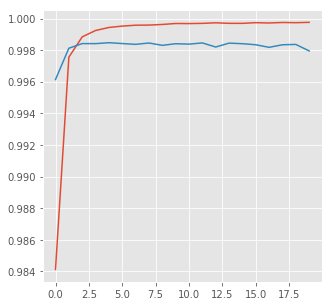

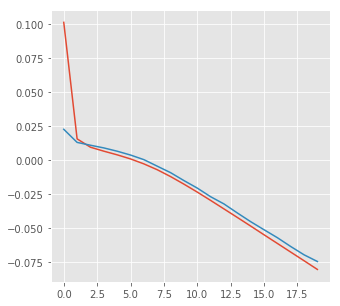

In [14]:
hist = pd.DataFrame(history.history)

import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(5,5))
plt.plot(hist["crf_viterbi_accuracy"])
plt.plot(hist["val_crf_viterbi_accuracy"])

plt.figure(figsize=(5,5))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()

In [15]:
#### Get the prediction on the test dataset

test_pred=model.predict(X_te, verbose=1)
#print(test_y_pred)
#print(np.argmax(test_y_pred,axis=2))

#K.clear_session()

6363/6363 [==============================] - 11s 2ms/step


In [16]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_te)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

print(classification_report(test_labels, pred_labels, digits=4))

F1-score: 95.9%
             precision    recall  f1-score   support

    MINERAL     0.9706    0.9887    0.9795      4235
       ROCK     0.9292    0.9649    0.9467      4869
      STRAT     0.8996    0.9384    0.9186      1088
  TIMESCALE     0.9948    0.9965    0.9957       579
   LOCATION     0.9421    0.9774    0.9594      3896
ORE_DEPOSIT     0.9347    0.9862    0.9598       581

avg / total     0.9446    0.9748    0.9594     15248



In [ ]:
def get_prediction(i):
    sentence_tags = []
    p = model.predict(np.array([X_te[i]]))
    p = np.argmax(p, axis=-1)
    true = np.argmax(y_te[i], -1)
    #print("{:15}||{:12}||{}".format("Word", "True", "Pred"))
    #print(40 * "=")
    for w, t, pred in zip(X_te[i], true, p[0]):
        if w != 0:
            #print("{:15} {:12} {}".format(words[w-1], tags[t], tags[pred]))
            sentence_tags.append([words[w-1], tags[t], tags[pred]])
    return sentence_tags

In [ ]:
result = []
for i in range(0, len(test_pred)):
    result.append(get_prediction(i))
print(len(result))

In [ ]:
result[10]

In [ ]:
result_tag_found = []
for r in result:
    for w, t, p in r:
        if t == "O" and t is not p:
            result_tag_found.append(r)
            break
        if t is not "O" and p is not "O" and t is not p:
            result_tag_found.append(r)
            break
print(len(result_tag_found))

In [ ]:
result_tag_found[0]

In [ ]:
import csv

#out = csv.writer(open(r"/Users/majiga/Documents/wamex/data/tagged_sentences_CNN.csv","w"), delimiter=',',quoting=csv.QUOTE_ALL)
out = csv.writer(open(r"C:/wamex/data/tagged_sentences_CNN.csv","w", newline=''), delimiter=',',quoting=csv.QUOTE_ALL)
out.writerow(['Word', 'DictionaryTag', "PredictionTag"])
for r in result_tag_found:
    for w, t, p in r:
        out.writerow([w, t, p])
        if w == ".":
            out.writerow('')
            break

#with open(r"/Users/majiga/Documents/wamex/data/tagged_sentences.csv", w) as f:
print("DONE")